This notebook has 2 parts. 

In the first part, Naive Bayes Classifier method is implemented without any libraries. 

In the second part, same dataset was investigated through KNN and SVM using sklearn.

Python implementation 


In [1]:
from csv import reader
from random import seed
from random import randrange
from math import sqrt
from math import exp
from math import pi

In [21]:
from google.colab import files
uploaded = files.upload()

Saving iris.csv to iris.csv


In [2]:
# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

In [6]:
def str_to_float(dataset, col):
  for row in dataset:
    row[col] = float(row[col].strip())

In [7]:
def str_to_int(dataset,col):
  class_vals = [row[col] for row in dataset]
  unique = set(class_vals)
  lookup = dict()

  for i, val in enumerate(unique):
    lookup[val] = i

  for row in dataset:
    row[col] = lookup[row[col]]
  
  return lookup

In [9]:
# Splitting the dataset into k folds

def cross_validation_split(dataset, n_folds):
  dataset_split = list()
  dataset_copy = list(dataset)
  fold_size = int(len(dataset) / n_folds)

  for i in range(n_folds):
    fold = list()

    while len(fold) < fold_size:
      index = randrange(len(dataset_copy))
      fold.append(dataset_copy.pop(index))
    
    dataset_split.append(fold)
  
  return dataset_split
   


In [10]:
def accuracy_percentage(actual,predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [11]:
# Evaluation after implementing cross validation split

def evaluate_algo(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_percentage(actual, predicted)
		scores.append(accuracy)
	return scores


In [12]:
# Split dataset by class values 0,1,2

def separate_by_class(dataset):
	separated = dict()
	for i in range(len(dataset)):
		vector = dataset[i]
		class_value = vector[-1]
		if (class_value not in separated):
			separated[class_value] = list()
		separated[class_value].append(vector)
	return separated

In [14]:
# Functions for statistics metrics

def mean(numbers):
	return sum(numbers)/float(len(numbers))
 
def stdev(numbers):
	avg = mean(numbers)
	variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
	return sqrt(variance)
 
# Mean, stdev and count for each col in dataset
def summarize_dataset(dataset):
	summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
	del(summaries[-1])
	return summaries

In [15]:
# Split dataset by class then calculate statistics for each row
def summarize_by_class(dataset):
	separated = separate_by_class(dataset)
	summaries = dict()
	for class_value, rows in separated.items():
		summaries[class_value] = summarize_dataset(rows)
	return summaries

In [16]:
# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev):
	exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
	return (1 / (sqrt(2 * pi) * stdev)) * exponent

In [17]:
# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
	total_rows = sum([summaries[label][0][2] for label in summaries])
	probabilities = dict()
	for class_value, class_summaries in summaries.items():
		probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
		for i in range(len(class_summaries)):
			mean, stdev, _ = class_summaries[i]
			probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
	return probabilities

In [18]:
# Predict the class for a given row
def predict(summaries, row):
	probabilities = calculate_class_probabilities(summaries, row)
	best_label, best_prob = None, -1
	for class_value, probability in probabilities.items():
		if best_label is None or probability > best_prob:
			best_prob = probability
			best_label = class_value
	return best_label

In [19]:
# Naive Bayes Algorithm
def naive_bayes(train, test):
	summarize = summarize_by_class(train)
	predictions = list()
	for row in test:
		output = predict(summarize, row)
		predictions.append(output)
	return(predictions)

In [23]:
# Test Naive Bayes on Iris Dataset
seed(1)
filename = 'iris.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
	str_to_float(dataset, i)
# convert class column to integers
str_to_int(dataset, len(dataset[0])-1)
# evaluate algorithm
n_folds = 5
scores = evaluate_algo(dataset, naive_bayes, n_folds)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [93.33333333333333, 96.66666666666667, 100.0, 93.33333333333333, 93.33333333333333]
Mean Accuracy: 95.333%


KNN

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
df = pd.read_csv('iris.csv', header=None)
df.rename(columns = {4:'Type'},inplace=True)

In [97]:
df.head()

,0,1,2,3,Type
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [98]:
# Null val check.
df.isnull().values.any()

False

In [99]:
def classification(s):
  if s == 'Iris-setosa':
    return 0
  if s == 'Iris-versicolor':
    return 1
  if s == 'Iris-virginica':
    return 2

In [100]:
df['Type'] = df['Type'].map(classification)

In [101]:
df['Type']

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: Type, Length: 150, dtype: int64

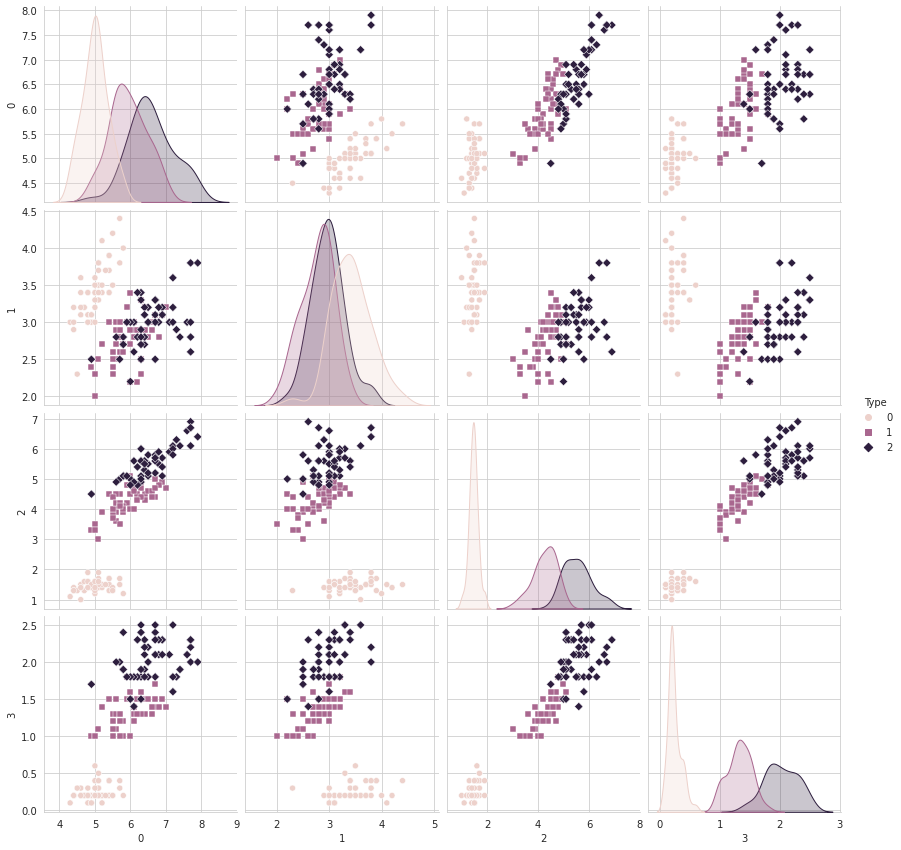

In [104]:
sns.set_style('whitegrid')
sns.pairplot(df, hue='Type',height=3, markers = ['o','s','D'])
plt.show()

In [124]:
X = df.drop(['Type'],axis=1)
y = df['Type']

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [134]:
knn = KNeighborsClassifier()

In [135]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [136]:
predictions = knn.predict(X_test)

In [137]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [138]:
print(confusion_matrix(y_test,predictions))

[[19  0  0]
 [ 0 14  1]
 [ 0  1 10]]


In [139]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      0.93      0.93        15
           2       0.91      0.91      0.91        11

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



Support Vector Classifier

In [140]:
from sklearn.svm import SVC

In [152]:
svc = SVC(C=10, gamma = 0.01)

In [153]:
svc.fit(X_train,y_train)

SVC(C=10, gamma=0.01)

In [154]:
predictions = svc.predict(X_test)

In [155]:
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test,predictions))

[[19  0  0]
 [ 0 14  1]
 [ 0  1 10]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      0.93      0.93        15
           2       0.91      0.91      0.91        11

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



In [145]:
from sklearn.model_selection import GridSearchCV

In [146]:
param_grid = {'C': [0.01,0.1,1,10,100,1000], 'gamma': [1,0.1,0.01,0.001,0.0001]}

In [147]:
grid = GridSearchCV(SVC(), param_grid, verbose=3)

In [148]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ...................C=0.01, gamma=1;, score=0.333 total time=   0.0s
[CV 2/5] END ...................C=0.01, gamma=1;, score=0.381 total time=   0.0s
[CV 3/5] END ...................C=0.01, gamma=1;, score=0.381 total time=   0.0s
[CV 4/5] END ...................C=0.01, gamma=1;, score=0.381 total time=   0.0s
[CV 5/5] END ...................C=0.01, gamma=1;, score=0.381 total time=   0.0s
[CV 1/5] END .................C=0.01, gamma=0.1;, score=0.333 total time=   0.0s
[CV 2/5] END .................C=0.01, gamma=0.1;, score=0.381 total time=   0.0s
[CV 3/5] END .................C=0.01, gamma=0.1;, score=0.381 total time=   0.0s
[CV 4/5] END .................C=0.01, gamma=0.1;, score=0.381 total time=   0.0s
[CV 5/5] END .................C=0.01, gamma=0.1;, score=0.381 total time=   0.0s
[CV 1/5] END ................C=0.01, gamma=0.01;, score=0.333 total time=   0.0s
[CV 2/5] END ................C=0.01, gamma=0.01

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=3)

In [149]:
grid.best_params_

{'C': 10, 'gamma': 0.01}